# 準備

In [1]:
#GPUを確認
!nvidia-smi

Thu Sep 30 02:39:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#transformersをインポート
!pip install transformers

     |████████████████████████████████| 2.9 MB 8.7 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 3.3 MB 60.6 MB/s 
     |████████████████████████████████| 636 kB 78.6 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [274]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import os
import glob
import re
import nltk
nltk.download('punkt')
import collections
import scipy
import math
import gc
import random
import time
import datetime
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, fbeta_score
from tqdm.notebook import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#GPUに渡すための変数device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
#出力フォルダの指定
DATA_DIR = "./"
OUTPUT_DIR = "Output/"
warnings.filterwarnings("ignore")

In [10]:
#GoogleDriveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#作業ディレクトリの移動
%cd /content/drive/MyDrive/Colab Notebooks/Signate論文コンペ

/content/drive/MyDrive/Colab Notebooks/Signate論文コンペ


# データの読み込み

In [328]:
train_data = pd.read_csv(DATA_DIR + "train.csv")
test_data = pd.read_csv(DATA_DIR + "test.csv")

In [331]:
train_data.head(10)

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0
5,5,From bench to bedside: Molecular imaging in in...,Purpose of review Standard structural imaging ...,0
6,6,Left gonadal vein thrombosis in a patient with...,COVID-19 disease is a viral illness that predo...,0
7,7,Development and validation of a prediction mod...,OBJECTIVES: We aimed to develop and validate a...,0
8,8,Rehabilitation and Covid-19: the Cochrane Reha...,INTRODUCTION: This paper improves the methodol...,0
9,9,Slow gait in MCI is associated with ventricula...,Slow gait is ubiquitous among older adults and...,0


In [332]:
test_data.head(10)

,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...
5,27150,Anthraquinone Derivatives as an Immune Booster...,Anthraquinone derivatives are identified for t...
6,27151,Discriminatory and predictive capabilities of ...,BACKGROUND: Multiplex assays such as xMAP have...
7,27152,PET imaging of gliomas using novel tracers: A ...,NaN
8,27153,Symmetrical nail bed uptake on a (99m)Tc-HDP b...,NaN
9,27154,Automatic brain MR images diagnosis based on e...,A new automatic system to detect pathologies i...


## titleとabstractを結合

In [19]:
train_data["text"] = train_data["title"] + " " + train_data["abstract"].fillna("")
test_data["text"] = test_data["title"] + " " + test_data["abstract"].fillna("")
train_data = train_data.drop(["title","abstract"],axis=1)
test_data = test_data.drop(["title","abstract"],axis=1)

In [20]:
train_data.head(10)

,id,judgement,text
0,0,0,One-year age changes in MRI brain volumes in o...
1,1,0,Supportive CSF biomarker evidence to enhance t...
2,2,0,Occurrence of basal ganglia germ cell tumors w...
3,3,0,New developments in diagnosis and therapy of C...
4,4,0,Prolonged shedding of SARS-CoV-2 in an elderly...
5,5,0,From bench to bedside: Molecular imaging in in...
6,6,0,Left gonadal vein thrombosis in a patient with...
7,7,0,Development and validation of a prediction mod...
8,8,0,Rehabilitation and Covid-19: the Cochrane Reha...
9,9,0,Slow gait in MCI is associated with ventricula...


In [21]:
test_data.head(10)

,id,text
0,27145,Estimating the potential effects of COVID-19 p...
1,27146,Leukoerythroblastic reaction in a patient with...
2,27147,[15O]-water PET and intraoperative brain mappi...
3,27148,Adaptive image segmentation for robust measure...
4,27149,Comparison of Epidemiological Variations in CO...
5,27150,Anthraquinone Derivatives as an Immune Booster...
6,27151,Discriminatory and predictive capabilities of ...
7,27152,PET imaging of gliomas using novel tracers: A ...
8,27153,Symmetrical nail bed uptake on a (99m)Tc-HDP b...
9,27154,Automatic brain MR images diagnosis based on e...


# データの前理解

## 事前学習モデルのトークンを調べる

In [15]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

In [17]:
tokenizer.vocab

{'nonselective': 24192,
 'mature': 6681,
 '121': 14162,
 'rabbits': 7474,
 'heterozygosity': 18143,
 'concerted': 22758,
 'microvessels': 23457,
 '##43': 9094,
 'spectrum': 5351,
 '##ȼ': 1599,
 'postulate': 22169,
 '##ichia': 6305,
 'contemporary': 12653,
 'neuroprotective': 12752,
 'relatedness': 19645,
 'nut': 23151,
 'qual': 2781,
 'tubular': 9292,
 'urticaria': 22056,
 '##parous': 28484,
 'simvastatin': 18236,
 'cultivation': 13579,
 'nhe': 19958,
 'astigm': 20384,
 'predictable': 16705,
 'teratogenic': 27992,
 'incidental': 17297,
 'annulus': 21745,
 '##n4': 22629,
 'manufact': 8795,
 'flocc': 23172,
 'goat': 17757,
 'aic': 24571,
 'occult': 15933,
 'writing': 16129,
 'kernel': 20014,
 'intoxic': 25283,
 '##p2': 10438,
 '##clim': 14393,
 'compromising': 21727,
 '٭': 350,
 'migratory': 17282,
 'μm': 6370,
 'compress': 23590,
 'mz': 20687,
 '##ab': 1761,
 'flun': 27570,
 'apob': 16748,
 'regularity': 28182,
 '##atig': 7262,
 'changes': 2458,
 'mit': 3279,
 'resection': 4774,
 'medic

## 512を超える文章の数を調べる

In [22]:
max_lens_train = []
i = 0
for x in train_data["text"]:
    max_lens_train.append(len(tokenizer.tokenize(x)))
    max_lens = (len(tokenizer.tokenize(x)))
    if max_lens >= 256:
        i += 1     
        
max_lens_test = []
j = 0
for x in test_data["text"]:
    max_lens_test.append(len(tokenizer.tokenize(x)))
    max_lens = (len(tokenizer.tokenize(x)))
    if max_lens >= 256:
        j += 1

print("最大値：",max(max_lens_train),",trainの文字数512オーバーは",i)
print("最大値：",max(max_lens_test),",testの文字数512オーバーは",j)

最大値： 2478 ,trainの文字数512オーバーは 14876
最大値： 3615 ,testの文字数512オーバーは 22458


## 文書の長さの分布

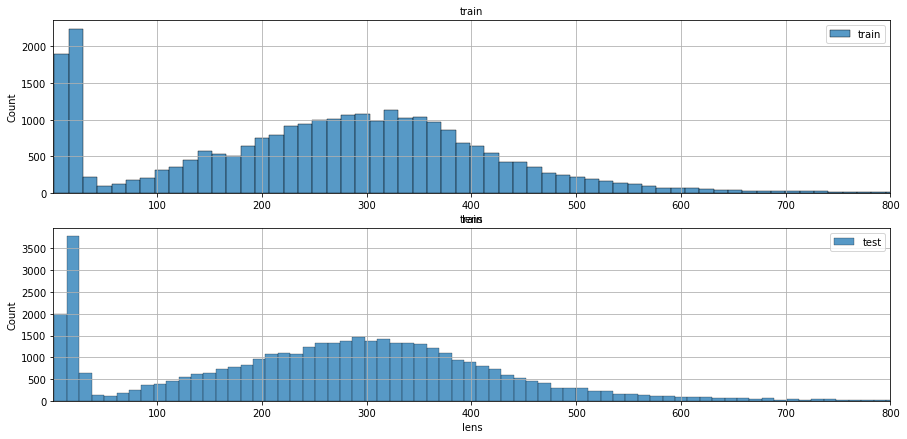

In [23]:
# 分布を出力
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(15,7))

sns.histplot(max_lens_train, ax = ax1, label = "train")
ax1.legend(loc="lower right",fontsize=30)
ax1.set_xlabel(xlabel="lens")
ax1.grid()
ax1.set_title("train",fontsize=10)
ax1.set_xlim(1,800)
ax1.legend(loc='upper right',fontsize=10)

sns.histplot(max_lens_test, ax = ax2, label = "test")
ax2.legend(loc="lower right",fontsize=20)
ax2.set_xlabel(xlabel="lens")
ax2.grid()
ax2.set_title("train",fontsize=10)
ax2.set_xlim(1,800)
ax2.legend(loc='upper right',fontsize=10)

# BERTのモデル学習

## input_idsとAttentionの取得
- 文章をトークンに分ける  
- スペシャルトークン[CLS],[SEP]を追加  
- トークンにIDを付与(input_ids)
- Attentionを付与(attention_masks)
- 文章を同じ長さ(max_length)に統一するために、切り捨てor[PAD]を追加

In [24]:
text_list = train_data['text'].tolist()

encoded_dict = tokenizer.batch_encode_plus(
                                            text_list,
                                            add_special_tokens = True,      # [CLS]と[SEP]を追加
                                            max_length = 10,                # 最大トークン数
                                            truncation=True,                # 切り捨て
                                            pad_to_max_length = True,       # paddingの方法(512に満たない場合は[PAD]を追加）
                                            return_attention_mask = True,   # attention_mask : 入力トークン(1)とパディングトークン(0)を区別
                                            return_tensors = 'pt'           # pytorchのテンソル型に渡す
                                            )

input_ids = encoded_dict.input_ids
attention_masks = encoded_dict.attention_mask
labels = torch.Tensor(train_data['judgement'])

## 学習用データと検証用データに分割

In [25]:
# データセットの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.3)

print("train_dataset Size :", len(train_dataset))
print("val_dataset Size :", len(val_dataset))

train_dataset Size : 19001
val_dataset Size : 8144


## DataLoaderの作成<br>
batch_size毎にデータをモデルに学習させる

In [26]:
batch_size = 16

train_dataloader = DataLoader(
                            train_dataset,                              # The training samples.
                            sampler = RandomSampler(train_dataset),     # 重複無しでランダムな順番で読み込む(shuffle=Trueでも同じ)
                            batch_size = batch_size,                    # Trains with this batch size.
                            drop_last=True                              # batchサイズで割り切れなかった分は切り捨てる
                            )

validation_dataloader = DataLoader(
                                    val_dataset,                                # The validation samples.
                                    sampler = SequentialSampler(val_dataset),   # 重複無しで順番で読み込む(shuffle=Falseでも同じ)
                                    batch_size = batch_size)                    # Evaluate with this batch size.

In [27]:
print("train_dataLoader Size:", len(train_dataloader))
print(train_dataloader.dataset[0])
print()
print("validation_dataloader Size:", len(validation_dataloader))
print(validation_dataloader.dataset[0])

train_dataLoader Size: 1187
(tensor([    2,  1877,  2727, 14290,  1690,  3594,  2209,  2446,  1682,     3]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(0.))

validation_dataloader Size: 509
(tensor([   2, 1680, 4082, 1685, 4306, 1690, 3476, 2169, 1755,    3]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), tensor(0.))


## モデルの定義

In [208]:
model = AutoModelForSequenceClassification.from_pretrained(
                                                            "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
                                                            num_labels=1,
                                                            output_attentions = False,                              # False:attentionは出力しない
                                                            output_hidden_states = True                             # True:隠れ層を出力
                                                        )
model.resize_token_embeddings(len(tokenizer))   #入力トークンのサイズに変更する
model.cuda()    # GPUに渡す

model   #modelの構造を確認

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSeque

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28895, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

## 最適化関数の定義

In [214]:
optimizer = AdamW(model.parameters(),   # パラメータ
                  lr = 2e-5,            # 学習率(デフォルトは1e-3)
                  eps = 1e-8            # 数値を安定させるため分母に追加する項(デフォルトは1e-8)
                )

## スケジュラーの定義
総ステップごとに学習率を変化させていく

In [215]:
epochs = 5

total_steps = len(train_dataloader) * epochs # [トレーニングステップ数] = [ミニバッチ数] × [エポック数]

#ウォームアップ期間が0からオプティマイザーに設定された初期lrまで直線的に増加した後、オプティマイザーに設定された初期lrから0に直線的に減少する学習率でスケジュールを作成
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,               # ウォームアップフェーズのステップ数
                                            num_training_steps = total_steps)   #トレーニングステップの総数

## その他関数

**時間計測**

In [216]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**評価関数の定義**

In [217]:
   def BestScore(labels, prediction):

        Threshold_list = []
        # accuracy_score_list = []
        # recall_score_list = []
        # precision_score_list = []
        fbeta_score_list = []
        confusion_matrix_list = []
        classification_report_list = []
        
        for i in range(1000):
            Threshold = i*0.0001
            predictions = np.where(prediction < Threshold, 0, 1)
            Threshold_list.append(Threshold)

            #accuracy_score_list.append(accuracy_score(labels, predictions)
            #recall_score_list.append(recall_score(labels, predictions))
            #precision_score_list.append(precision_score(labels, predictions))
            fbeta_score_list.append(fbeta_score(labels, predictions, beta=7.0))
            confusion_matrix_list.append(confusion_matrix(labels, predictions))
            classification_report_list.append(classification_report(labels, predictions))
                    
        for Threshold, Fbeta_score, Confusion_Matrix, Classification_Report in zip(Threshold_list, fbeta_score_list, confusion_matrix_list, classification_report_list):
            if Fbeta_score == max(fbeta_score_list):
                return Threshold, Fbeta_score, Confusion_Matrix, Classification_Report
                break

## 学習本番

In [218]:
#生成される乱数をあらかじめ指定
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


Sigmoid = torch.nn.Sigmoid()
Criterion = torch.nn.BCELoss()

logits_list = []
training_stats = []

best_val_loss = np.inf

# トレーニング時間計測するために現在の時間情報を取得
total_t0 = time.time()

epochs = 5

for epoch in range(0, epochs):
    
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')

    t0 = time.time()
    step_train_loss = 0
    total_train_loss = 0
    step_val_loss = 0
    total_val_loss = 0
    
    model.train()

    for step, (input_ids, attention_masks, labels) in enumerate(train_dataloader):

        input_ids = input_ids.to(device)               # トークンIDの行列
        attention_masks = attention_masks.to(device)   # attention_maskの行列
        labels = labels.to(device)                     # ラベルデータ
        
        optimizer.zero_grad()   #最適化対象の全ての勾配を初期化

        outputs = model(input_ids=input_ids, 
                        attention_mask = attention_masks)

        y_proba = Sigmoid(outputs.logits).squeeze()
        
        loss = Criterion(y_proba, labels)               #損失を出力
        step_train_loss += loss.item()*batch_size     #step毎の損失
        loss.backward()                                 #勾配(微分)を計算する

        optimizer.step()    # パラメータを更新し、計算された勾配を使ってステップを踏む。オプティマイザは、学習率などに基づいてパラメータをどのように変更するか、「更新ルール」を決定する。　
                            # 勾配や学習率などに基づいて、パラメータをどのように変更するかを決定します。

        if (step % 100 == 0 and not step==0) or step==(len(train_dataloader)-1):
            elapsed = format_time(time.time() - t0)
            total_train_loss = step_train_loss/step
            print('  【Batch {:>5,}  of  {:>5,}    Elapsed: {:}】       Train Loss {:.5f}'.format(step, len(train_dataloader)-1, elapsed, total_train_loss))

    scheduler.step()    # 学習率の更新
    
    # トレーニング時間計測
    training_time = format_time(time.time() - t0)

    print()
    print("  Average training loss: {0:.5f}".format(total_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               評価
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()  # モデルを評価モードに変更（dropout & batch norm の切り替え）

    total_eval_accuracy = 0
    total_eval_fbeta_score = 0

    total_eval_loss = 0
    nb_eval_steps = 0

    y_proba_list = []

    for step, (input_ids, attention_masks, labels) in enumerate(validation_dataloader):
        
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():        
            outputs = model(input_ids, 
                            attention_mask=attention_masks)
        
        y_proba = Sigmoid(outputs.logits).squeeze()
        
        loss = Criterion(y_proba, labels)    #損失を出力
        
        step_val_loss += loss.item()*batch_size      #step毎の損失
        
        if  (step % 100 == 0 and not step==0) or step==(len(validation_dataloader)-1):
            elapsed = format_time(time.time() - t0)
            total_val_loss = step_val_loss/step
            print('  【Batch {:>5,}  of  {:>5,}    Elapsed: {:}】       Validation Loss {:.5f}'.format(step, len(validation_dataloader)-1, elapsed, total_val_loss))
             
        logits = outputs.logits.detach().cpu().numpy()  # detach:tensor型から勾配情報を抜く cpu():CPUに切り替える
        labels = labels.to('cpu').numpy()
        
        y_proba_list.append(y_proba.to("cpu").numpy())


    prediction = np.concatenate(y_proba_list)
    labels = np.array([i[2] for i in val_dataset])
    
    Threshold, Fbeta_Score, Confusion_Matrix, Classification_Report = BestScore(labels, prediction)
    
    
    validation_time = format_time(time.time() - t0)
    print()
    print("  <Finished>")
    print("  Validation Loss: {0:.5f}".format(total_val_loss))
    print("  Validation took: {:}".format(validation_time))
    print()
    print(   "<Result>")
    print("  Threshold: {0:.5f}".format(Threshold))
    print("  f-bata-score: {0:.5f}".format(Fbeta_Score))
    print("  confusion_matrix:")
    print(Confusion_Matrix)
    print("  classification_report:")
    print(Classification_Report)

    if total_val_loss < best_val_loss:
        best_stats = []
        best_epoch = epoch+1
        best_val_score = total_val_loss
        best_score = Fbeta_Score
        best_Threshold = Threshold
              
        best_stats.append(
                        {
                            "epoch":best_epoch,
                            "best_val_score":best_val_score,
                            "best_score":best_score,
                            "best_Threshold":best_Threshold
                        }
                        )

    training_stats.append(
                        {
                        'epoch': epoch + 1,
                        'Training Loss': total_train_loss,
                        'Valid. Loss': total_val_loss,
                        'Valid. FbetaScore.': Fbeta_Score,
                        'Training Time': training_time,
                        'Validation Time': validation_time
                        }
                        )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  【Batch   101  of  1,187    Elapsed: 0:00:05】       Train Loss 2.19422
  【Batch   201  of  1,187    Elapsed: 0:00:09】       Train Loss 1.90552
  【Batch   301  of  1,187    Elapsed: 0:00:14】       Train Loss 1.80929
  【Batch   401  of  1,187    Elapsed: 0:00:18】       Train Loss 1.69032
  【Batch   501  of  1,187    Elapsed: 0:00:23】       Train Loss 1.64533
  【Batch   601  of  1,187    Elapsed: 0:00:28】       Train Loss 1.59414
  【Batch   701  of  1,187    Elapsed: 0:00:32】       Train Loss 1.54947
  【Batch   801  of  1,187    Elapsed: 0:00:37】       Train Loss 1.52634
  【Batch   901  of  1,187    Elapsed: 0:00:41】       Train Loss 1.52927
  【Batch 1,001  of  1,187    Elapsed: 0:00:46】       Train Loss 1.53230
  【Batch 1,101  of  1,187    Elapsed: 0:00:51】       Train Loss 1.49242
  【Batch 1,187  of  1,187    Elapsed: 0:00:55】       Train Loss 1.48820

  Average training loss: 1.48820
  Training epcoh took: 0:00:55

Running Validation...
  【Ba

## 学習結果

**スタッツ**

In [220]:
training_stats

[{'Training Loss': 1.488200210832675,
  'Training Time': '0:00:55',
  'Valid. FbetaScore.': 0.7298875432525951,
  'Valid. Loss': 1.0206163193971858,
  'Validation Time': '0:00:40',
  'epoch': 1},
 {'Training Loss': 0.99011196314497,
  'Training Time': '0:00:54',
  'Valid. FbetaScore.': 0.768994155644417,
  'Valid. Loss': 0.9917659153905147,
  'Validation Time': '0:00:40',
  'epoch': 2},
 {'Training Loss': 0.6297955170704105,
  'Training Time': '0:00:54',
  'Valid. FbetaScore.': 0.7382972038956958,
  'Valid. Loss': 1.1270445248123082,
  'Validation Time': '0:00:40',
  'epoch': 3},
 {'Training Loss': 0.3524534286715995,
  'Training Time': '0:00:54',
  'Valid. FbetaScore.': 0.6920743268866135,
  'Valid. Loss': 1.361645521225745,
  'Validation Time': '0:00:39',
  'epoch': 4},
 {'Training Loss': 0.23560586317307292,
  'Training Time': '0:00:54',
  'Valid. FbetaScore.': 0.701134660672233,
  'Valid. Loss': 1.577981919626335,
  'Validation Time': '0:00:39',
  'epoch': 5}]

**Bestスタッツ**

In [221]:
best_stats

[{'best_Threshold': 0.0004,
  'best_score': 0.701134660672233,
  'best_val_score': 1.577981919626335,
  'epoch': 5}]

# 作成したBERTモデルでtestデータを予測

## input_idsとAttentionの取得

In [222]:
text_list = test_data['text'].tolist()

encoded_dict = tokenizer.batch_encode_plus(
                                            text_list,
                                            add_special_tokens = True,      # [CLS]と[SEP]を追加
                                            max_length = 10,                # 最大トークン数
                                            pad_to_max_length = True,       # paddingの方法(512に満たない場合は[PAD]を追加）
                                            return_attention_mask = True,   # attention_mask : 入力トークン(1)とパディングトークン(0)を区別
                                            return_tensors = 'pt'           # pytorchのテンソル型に渡す
                                            )

input_ids = encoded_dict.input_ids
attention_masks = encoded_dict.attention_mask

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## Datasetの作成

In [224]:
test_dataset = TensorDataset(input_ids, attention_masks)

print('{:>5,} test dataset'.format(len(test_dataset)))

40,834 test dataset


## DataLoaderの作成

In [317]:
batch_size = 16   #8以上だと動かない

test_dataloader = DataLoader(
                            test_dataset,                               # The training samples.
                            batch_size = batch_size,                    # Trains with this batch size
                            shuffle=False
                            )

## testデータを学習

In [319]:
#生成される乱数をあらかじめ指定
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Sigmoid = torch.nn.Sigmoid()

proba_list = []

# ========================================
#               評価
# ========================================
print("")
print("Running test...")

t0 = time.time()

model.eval()  # モデルを評価モードに変更（dropout & batch norm の切り替え）

# Evaluate data for one epoch
for step, (input_ids, attention_masks) in enumerate(test_dataloader):
    
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    
    with torch.no_grad():        
        outputs = model(input_ids, 
                        attention_mask=attention_masks)

    logits = outputs.logits
    proba = Sigmoid(logits).squeeze()
    proba_list.append(proba.to("cpu").numpy())

    if  (step % 100 == 0 and not step==0) or step==(len(test_dataloader)-1):
        elapsed = format_time(time.time() - t0)
        print('  【Batch {:>5,}  of  {:>5,}    Elapsed: {:}】'.format(step, len(test_dataloader)-1, elapsed))

proba = np.concatenate(proba_list)
print("Finished!!")


Running test...
  【Batch   100  of  2,552    Elapsed: 0:00:01】
  【Batch   200  of  2,552    Elapsed: 0:00:02】
  【Batch   300  of  2,552    Elapsed: 0:00:03】
  【Batch   400  of  2,552    Elapsed: 0:00:03】
  【Batch   500  of  2,552    Elapsed: 0:00:04】
  【Batch   600  of  2,552    Elapsed: 0:00:05】
  【Batch   700  of  2,552    Elapsed: 0:00:06】
  【Batch   800  of  2,552    Elapsed: 0:00:07】
  【Batch   900  of  2,552    Elapsed: 0:00:08】
  【Batch 1,000  of  2,552    Elapsed: 0:00:08】
  【Batch 1,100  of  2,552    Elapsed: 0:00:09】
  【Batch 1,200  of  2,552    Elapsed: 0:00:10】
  【Batch 1,300  of  2,552    Elapsed: 0:00:11】
  【Batch 1,400  of  2,552    Elapsed: 0:00:12】
  【Batch 1,500  of  2,552    Elapsed: 0:00:13】
  【Batch 1,600  of  2,552    Elapsed: 0:00:13】
  【Batch 1,700  of  2,552    Elapsed: 0:00:14】
  【Batch 1,800  of  2,552    Elapsed: 0:00:15】
  【Batch 1,900  of  2,552    Elapsed: 0:00:16】
  【Batch 2,000  of  2,552    Elapsed: 0:00:17】
  【Batch 2,100  of  2,552    Elapsed: 0:00:

**確率**

In [327]:
proba

array([0.00017779, 0.0003512 , 0.00045464, ..., 0.00017123, 0.00050603,
       0.00032113], dtype=float32)

**ラベル付け**

In [321]:
prediction = np.where(proba<0.0004,0,1)

## 提出

In [325]:
submission = pd.Series(prediction)
submission.index=range(27145,67979)
#submission.to_csv(OUTPUT_DIR + 'submission.csv',header=None)

In [326]:
submission

27145    0
27146    0
27147    1
27148    0
27149    0
        ..
67974    0
67975    0
67976    0
67977    1
67978    0
Length: 40834, dtype: int64